In [19]:
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

In [10]:
import pandas as pd

# Load the Excel files
attendance_data = pd.read_excel('data/attendance.xlsx')
holiday_data = pd.read_excel('data/holiday.xlsx')
permission_data = pd.read_excel('data/permission.xlsx')

# Ensure Entry and Exit are in 'hh:mm:ss' format
attendance_data['Entry'] = pd.to_datetime(attendance_data['Entry'], format='%H:%M').dt.time
attendance_data['Exit'] = pd.to_datetime(attendance_data['Exit'], format='%H:%M').dt.time

# Convert Entry and Exit back to timedelta for accurate work hour calculations
attendance_data['Entry'] = pd.to_timedelta(attendance_data['Entry'].astype(str))
attendance_data['Exit'] = pd.to_timedelta(attendance_data['Exit'].astype(str))

# Calculate work hours per day (Exit - Entry)
attendance_data['Work_Hours'] = (attendance_data['Exit'] - attendance_data['Entry']).dt.total_seconds() / 3600

# Process permission data (Start and End times)
permission_data['Start'] = pd.to_datetime(permission_data['Start'], format='%H:%M:%S').dt.time
permission_data['End'] = pd.to_datetime(permission_data['End'], format='%H:%M:%S').dt.time

permission_data['Start'] = pd.to_timedelta(permission_data['Start'].astype(str))
permission_data['End'] = pd.to_timedelta(permission_data['End'].astype(str))

# Calculate permission hours
permission_data['Permission_Hours'] = (permission_data['End'] - permission_data['Start']).dt.total_seconds() / 3600

# Merge attendance data with permission data
attendance_with_permission = pd.merge(attendance_data, 
                                      permission_data[['Date', 'Department', 'Employee', 'Permission_Hours']], 
                                      on=['Date', 'Department', 'Employee'], how='left')

# Adjust work hours by subtracting permission hours
attendance_with_permission['Adjusted_Work_Hours'] = attendance_with_permission['Work_Hours'] - attendance_with_permission['Permission_Hours'].fillna(0)

# Process holiday data to exclude leave days
holiday_data['Start'] = pd.to_datetime(holiday_data['Start'])
holiday_data['End'] = pd.to_datetime(holiday_data['End'])

# Create a list of leave dates from the holiday data
leave_dates = []
for idx, row in holiday_data.iterrows():
    leave_dates += pd.date_range(row['Start'], row['End']).to_list()

# Mark rows where the employee was on leave
attendance_with_permission['On_Leave'] = attendance_with_permission['Date'].isin(leave_dates)

# Exclude leave days from attendance calculations
attendance_with_permission = attendance_with_permission[~attendance_with_permission['On_Leave']]

# Assuming a working day is 8 hours, calculate Overtime and Delay
attendance_with_permission['Overtime'] = attendance_with_permission['Adjusted_Work_Hours'] - 8
attendance_with_permission['Delay'] = 8 - attendance_with_permission['Adjusted_Work_Hours']

# Cast the Fine and Bonus columns to the correct data types
attendance_with_permission['Fine'] = 0.0
attendance_with_permission['Bonus'] = 0.0

# Calculate fines for delay
attendance_with_permission.loc[attendance_with_permission['Delay'] > 3, 'Fine'] = 0.02
attendance_with_permission.loc[attendance_with_permission['Delay'] > 10, 'Fine'] = 0.03
attendance_with_permission.loc[attendance_with_permission['Delay'] > 20, 'Fine'] = 0.05

# Calculate bonuses for overtime
attendance_with_permission.loc[attendance_with_permission['Overtime'] > 3, 'Bonus'] = 0.02
attendance_with_permission.loc[attendance_with_permission['Overtime'] > 10, 'Bonus'] = 0.03
attendance_with_permission.loc[attendance_with_permission['Overtime'] > 20, 'Bonus'] = 0.05

# Display the final result with fines and bonuses
attendance_with_permission.head()


,Date,Department,Employee,Entry,Exit,Work_Hours,Permission_Hours,Adjusted_Work_Hours,On_Leave,Overtime,Delay,Fine,Bonus
0,2024-07-01,IT,Aynur,0 days 09:05:00,0 days 14:50:00,5.750000,NaN,5.750000,False,-2.250000,2.250000,0.0,0.0
1,2024-07-02,IT,Aynur,0 days 09:30:00,0 days 18:30:00,9.000000,NaN,9.000000,False,1.000000,-1.000000,0.0,0.0
2,2024-07-03,IT,Aynur,0 days 10:10:00,0 days 18:20:00,8.166667,NaN,8.166667,False,0.166667,-0.166667,0.0,0.0
3,2024-07-04,IT,Aynur,0 days 09:05:00,0 days 18:12:00,9.116667,NaN,9.116667,False,1.116667,-1.116667,0.0,0.0
4,2024-07-05,IT,Aynur,0 days 09:01:00,0 days 18:11:00,9.166667,NaN,9.166667,False,1.166667,-1.166667,0.0,0.0


/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_57886/3292869780.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.02' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  attendance_data.loc[attendance_data['Delay'] > 3, 'Fine'] = 0.02
/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_57886/3292869780.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.02' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  attendance_data.loc[attendance_data['Overtime'] > 3, 'Bonus'] = 0.02


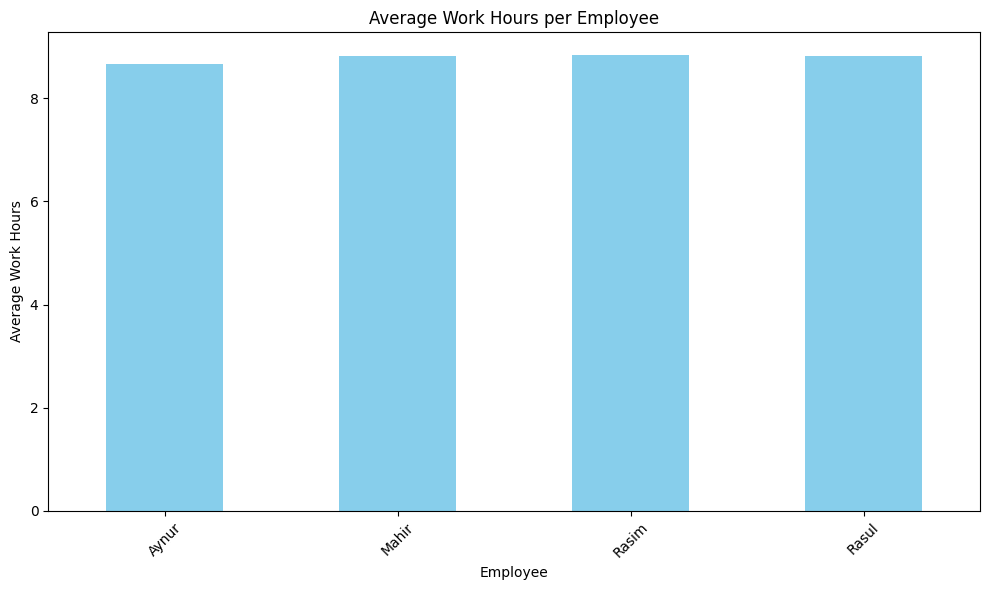

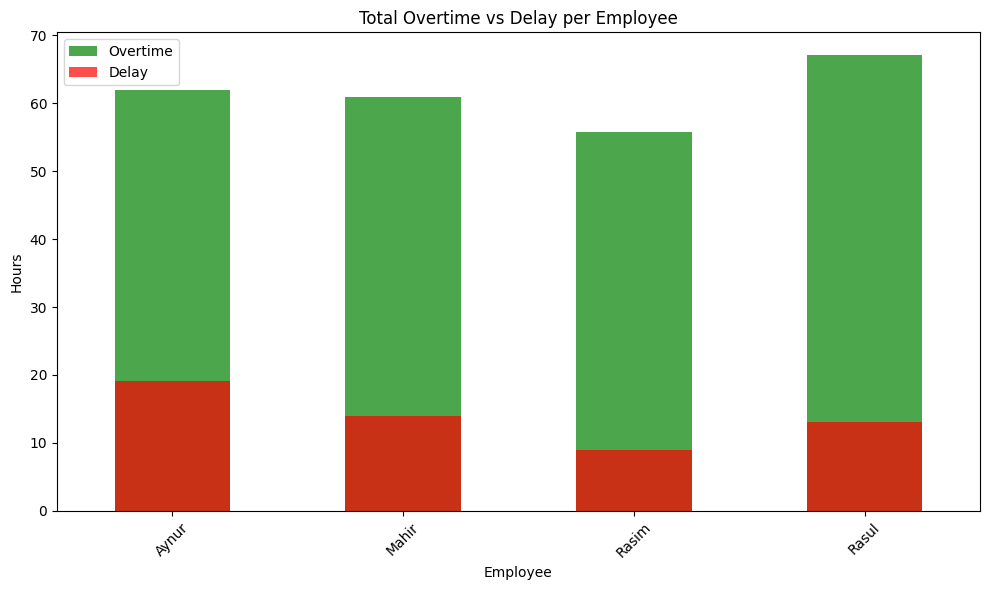

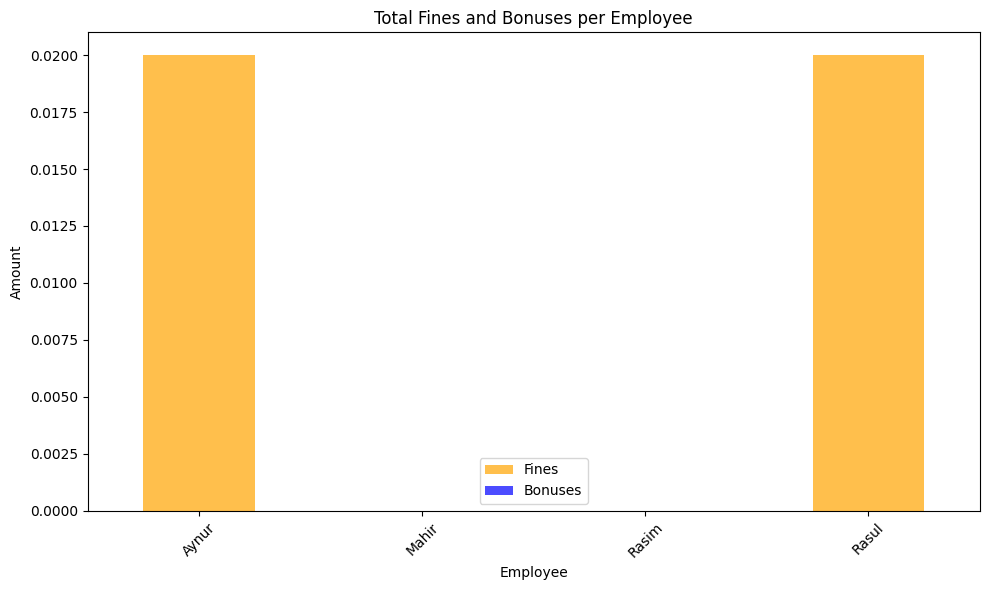

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the provided Excel files
attendance_data = pd.read_excel('data/attendance.xlsx')
holiday_data = pd.read_excel('data/holiday.xlsx')
permission_data = pd.read_excel('data/permission.xlsx')

# Convert Entry and Exit columns to datetime for time calculations
attendance_data['Entry'] = pd.to_datetime(attendance_data['Entry'], format='%H:%M')
attendance_data['Exit'] = pd.to_datetime(attendance_data['Exit'], format='%H:%M')

# Calculate work hours per day (Exit - Entry)
attendance_data['Work_Hours'] = (attendance_data['Exit'] - attendance_data['Entry']).dt.total_seconds() / 3600

# Assuming a working day is 8 hours, calculate Overtime and Delay
attendance_data['Overtime'] = attendance_data['Work_Hours'] - 8
attendance_data['Delay'] = 8 - attendance_data['Work_Hours']

# Remove negative values for Overtime and Delay where they do not apply
attendance_data['Overtime'] = attendance_data['Overtime'].apply(lambda x: x if x > 0 else 0)
attendance_data['Delay'] = attendance_data['Delay'].apply(lambda x: x if x > 0 else 0)

# Calculate fines for delay (based on rules provided)
attendance_data['Fine'] = 0
attendance_data.loc[attendance_data['Delay'] > 3, 'Fine'] = 0.02
attendance_data.loc[attendance_data['Delay'] > 10, 'Fine'] = 0.03
attendance_data.loc[attendance_data['Delay'] > 20, 'Fine'] = 0.05

# Calculate bonuses for overtime (based on rules provided)
attendance_data['Bonus'] = 0
attendance_data.loc[attendance_data['Overtime'] > 3, 'Bonus'] = 0.02
attendance_data.loc[attendance_data['Overtime'] > 10, 'Bonus'] = 0.03
attendance_data.loc[attendance_data['Overtime'] > 20, 'Bonus'] = 0.05

# Grouping data to calculate average work hours per employee
avg_work_hours = attendance_data.groupby('Employee')['Work_Hours'].mean()

# Grouping data to calculate total overtime and delay per employee
total_overtime = attendance_data.groupby('Employee')['Overtime'].sum()
total_delay = attendance_data.groupby('Employee')['Delay'].sum()

# Grouping data to calculate total fines and bonuses per employee
total_fines = attendance_data.groupby('Employee')['Fine'].sum()
total_bonuses = attendance_data.groupby('Employee')['Bonus'].sum()

# Create plots

# 1. Average Work Hours per Employee
plt.figure(figsize=(10, 6))
avg_work_hours.plot(kind='bar', color='skyblue')
plt.title('Average Work Hours per Employee')
plt.xlabel('Employee')
plt.ylabel('Average Work Hours')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Overtime and Delay per Employee
plt.figure(figsize=(10, 6))
total_overtime.plot(kind='bar', color='green', label='Overtime', alpha=0.7)
total_delay.plot(kind='bar', color='red', label='Delay', alpha=0.7)
plt.title('Total Overtime vs Delay per Employee')
plt.xlabel('Employee')
plt.ylabel('Hours')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Fines and Bonuses per Employee
plt.figure(figsize=(10, 6))
total_fines.plot(kind='bar', color='orange', label='Fines', alpha=0.7)
total_bonuses.plot(kind='bar', color='blue', label='Bonuses', alpha=0.7)
plt.title('Total Fines and Bonuses per Employee')
plt.xlabel('Employee')
plt.ylabel('Amount')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


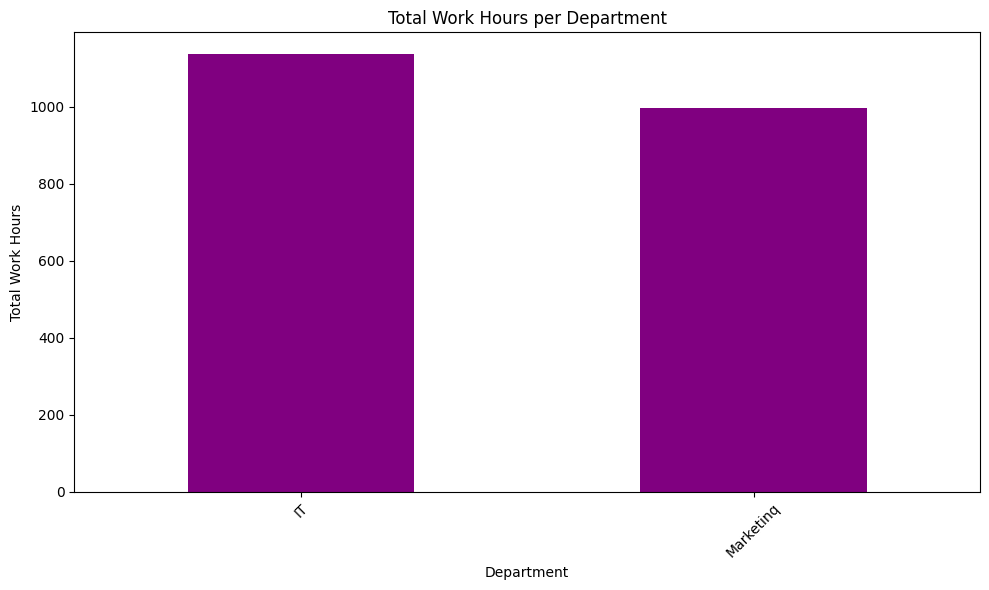

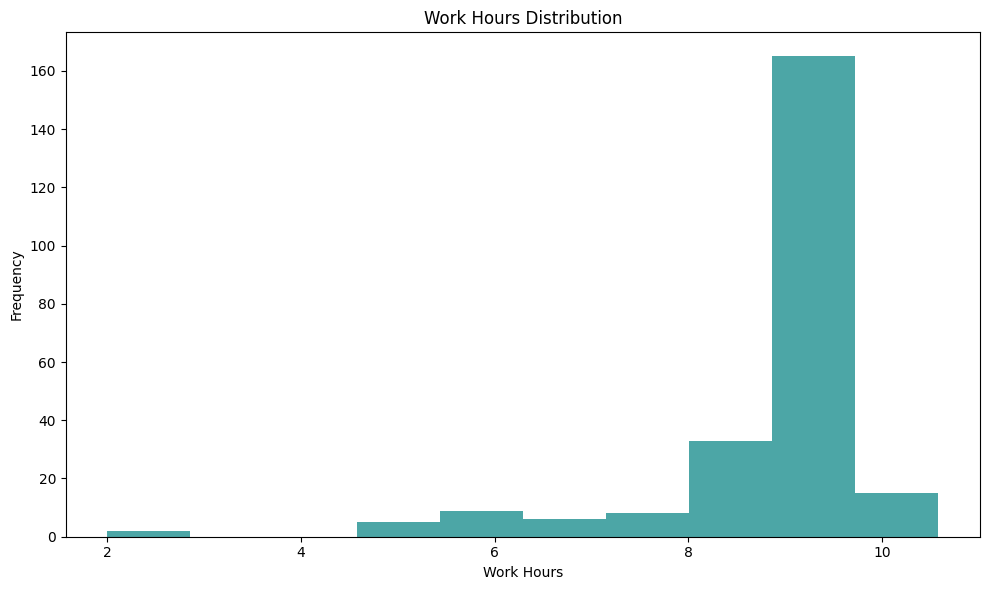

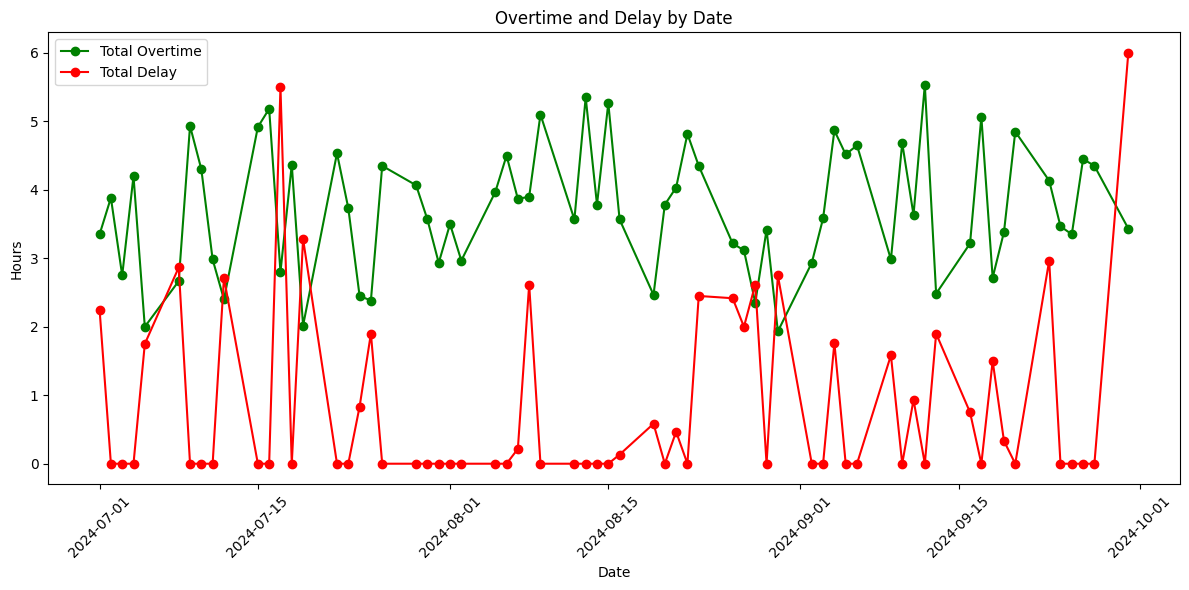

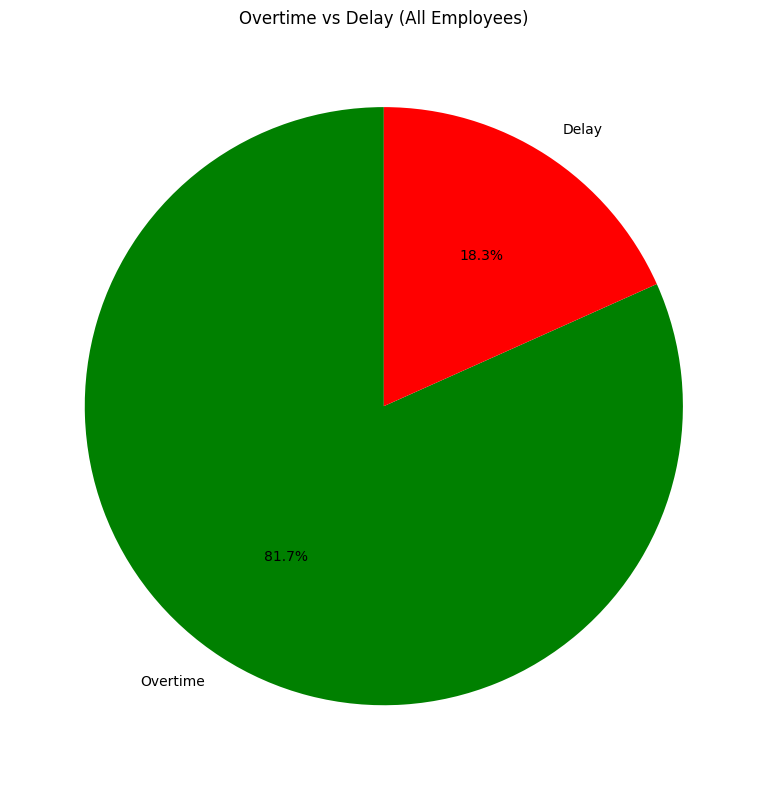

In [13]:
# 1. Total Work Hours per Department
total_work_hours_by_dept = attendance_data.groupby('Department')['Work_Hours'].sum()

plt.figure(figsize=(10, 6))
total_work_hours_by_dept.plot(kind='bar', color='purple')
plt.title('Total Work Hours per Department')
plt.xlabel('Department')
plt.ylabel('Total Work Hours')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Work Hours Distribution (Histogram)
plt.figure(figsize=(10, 6))
attendance_data['Work_Hours'].plot(kind='hist', bins=10, color='teal', alpha=0.7)
plt.title('Work Hours Distribution')
plt.xlabel('Work Hours')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 3. Overtime and Delay by Date (Line chart)
total_overtime_by_date = attendance_data.groupby('Date')['Overtime'].sum()
total_delay_by_date = attendance_data.groupby('Date')['Delay'].sum()

plt.figure(figsize=(12, 6))
plt.plot(total_overtime_by_date, label='Total Overtime', color='green', marker='o')
plt.plot(total_delay_by_date, label='Total Delay', color='red', marker='o')
plt.title('Overtime and Delay by Date')
plt.xlabel('Date')
plt.ylabel('Hours')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Pie Chart of Overtime vs Delay for all Employees
total_overtime_sum = attendance_data['Overtime'].sum()
total_delay_sum = attendance_data['Delay'].sum()

plt.figure(figsize=(8, 8))
plt.pie([total_overtime_sum, total_delay_sum], labels=['Overtime', 'Delay'], autopct='%1.1f%%', colors=['green', 'red'], startangle=90)
plt.title('Overtime vs Delay (All Employees)')
plt.tight_layout()
plt.show()


In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error

# Load the provided Excel files
attendance_data = pd.read_excel('data/attendance.xlsx')
holiday_data = pd.read_excel('data/holiday.xlsx')
permission_data = pd.read_excel('data/permission.xlsx')

# Convert Entry and Exit columns to datetime
attendance_data['Entry'] = pd.to_datetime(attendance_data['Entry'], format='%H:%M')
attendance_data['Exit'] = pd.to_datetime(attendance_data['Exit'], format='%H:%M')

# Calculate Work Hours per day (Exit - Entry)
attendance_data['Work_Hours'] = (attendance_data['Exit'] - attendance_data['Entry']).dt.total_seconds() / 3600

# Create basic time-based features
attendance_data['Day_of_Week'] = pd.to_datetime(attendance_data['Date']).dt.day_name()
attendance_data['Is_Weekend'] = attendance_data['Day_of_Week'].isin(['Saturday', 'Sunday']).astype(int)

# Calculate Overtime and Delay
attendance_data['Overtime'] = attendance_data['Work_Hours'] - 8
attendance_data['Delay'] = 8 - attendance_data['Work_Hours']

# Remove negative values for Overtime and Delay
attendance_data['Overtime'] = attendance_data['Overtime'].apply(lambda x: x if x > 0 else 0)
attendance_data['Delay'] = attendance_data['Delay'].apply(lambda x: x if x > 0 else 0)

# Calculate Cumulative and Rolling features
attendance_data['Cumulative_Overtime'] = attendance_data.groupby('Employee')['Overtime'].cumsum()
attendance_data['Cumulative_Delay'] = attendance_data.groupby('Employee')['Delay'].cumsum()
attendance_data['Rolling_Work_Hours'] = attendance_data.groupby('Employee')['Work_Hours'].rolling(window=7).mean().reset_index(0, drop=True)

# Calculate Total Leave Days (based on holiday data)
attendance_data['On_Leave'] = attendance_data['Date'].isin(holiday_data['Start'])
attendance_data['Total_Leave_Days'] = attendance_data.groupby('Employee')['On_Leave'].cumsum()

# Create cumulative fines and bonuses based on delays and overtime
attendance_data['Fine'] = 0
attendance_data.loc[attendance_data['Delay'] > 3, 'Fine'] = 0.02
attendance_data.loc[attendance_data['Delay'] > 10, 'Fine'] = 0.03
attendance_data.loc[attendance_data['Delay'] > 20, 'Fine'] = 0.05

attendance_data['Bonus'] = 0
attendance_data.loc[attendance_data['Overtime'] > 3, 'Bonus'] = 0.02
attendance_data.loc[attendance_data['Overtime'] > 10, 'Bonus'] = 0.03
attendance_data.loc[attendance_data['Overtime'] > 20, 'Bonus'] = 0.05

# Prepare final cumulative fines and bonuses
attendance_data['Cumulative_Fine'] = attendance_data.groupby('Employee')['Fine'].cumsum()
attendance_data['Cumulative_Bonus'] = attendance_data.groupby('Employee')['Bonus'].cumsum()

# Task 1: Predict Employee Absenteeism (classification)
# Target: Absenteeism (based on 'On_Leave' flag)
X_absenteeism = attendance_data[['Work_Hours', 'Overtime', 'Delay', 'Cumulative_Overtime', 'Total_Leave_Days', 'Is_Weekend']]
y_absenteeism = attendance_data['On_Leave']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_absenteeism, y_absenteeism, test_size=0.2, random_state=42)

# Train a classifier (Random Forest)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluation
print("Absenteeism Prediction - Accuracy:", accuracy_score(y_test, y_pred))
print("Absenteeism Prediction - Precision:", precision_score(y_test, y_pred))
print("Absenteeism Prediction - Recall:", recall_score(y_test, y_pred))

# Task 2: Predict Employee Performance (classification of overtime, delay, or fines)
# Predict if an employee will have overtime or delays
X_performance = attendance_data[['Work_Hours', 'Cumulative_Overtime', 'Cumulative_Delay', 'Is_Weekend', 'Total_Leave_Days']]
y_performance = np.where((attendance_data['Overtime'] > 0) | (attendance_data['Fine'] > 0), 1, 0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_performance, y_performance, test_size=0.2, random_state=42)

# Train a classifier (Random Forest)
clf_performance = RandomForestClassifier()
clf_performance.fit(X_train, y_train)

# Predictions
y_pred = clf_performance.predict(X_test)

# Evaluation
print("Performance Prediction - Accuracy:", accuracy_score(y_test, y_pred))
print("Performance Prediction - Precision:", precision_score(y_test, y_pred))
print("Performance Prediction - Recall:", recall_score(y_test, y_pred))

# Task 3: Predict Work Hours (regression)
# Target: Work Hours (regression)
X_work_hours = attendance_data[['Cumulative_Overtime', 'Cumulative_Delay', 'Is_Weekend', 'Total_Leave_Days']]
y_work_hours = attendance_data['Work_Hours']

# Handle missing values in Work Hours by imputing with mean
y_work_hours = y_work_hours.fillna(y_work_hours.mean())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_work_hours, y_work_hours, test_size=0.2, random_state=42)

# Train a regressor (Random Forest Regressor)
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

# Predictions
y_pred = regressor.predict(X_test)

# Evaluation
print("Work Hours Prediction - RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# Task 4: Predict Employee Turnover (classification)
# Create a hypothetical target for employee turnover (e.g., based on total fines/leave days)
attendance_data['Turnover'] = np.where(attendance_data['Cumulative_Fine'] > 0.1, 1, 0)

X_turnover = attendance_data[['Cumulative_Overtime', 'Cumulative_Fine', 'Total_Leave_Days', 'Is_Weekend']]
y_turnover = attendance_data['Turnover']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_turnover, y_turnover, test_size=0.2, random_state=42)

# Train a classifier (Random Forest)
clf_turnover = RandomForestClassifier()
clf_turnover.fit(X_train, y_train)

# Predictions
y_pred = clf_turnover.predict(X_test)

# Evaluation
print("Turnover Prediction - Accuracy:", accuracy_score(y_test, y_pred))
print("Turnover Prediction - Precision:", precision_score(y_test, y_pred))
print("Turnover Prediction - Recall:", recall_score(y_test, y_pred))


Absenteeism Prediction - Accuracy: 0.94
Absenteeism Prediction - Precision: 0.0
Absenteeism Prediction - Recall: 0.0
Performance Prediction - Accuracy: 1.0
Performance Prediction - Precision: 1.0
Performance Prediction - Recall: 1.0
Work Hours Prediction - RMSE: 0.9194685030002492
Turnover Prediction - Accuracy: 1.0
Turnover Prediction - Precision: 0.0
Turnover Prediction - Recall: 0.0


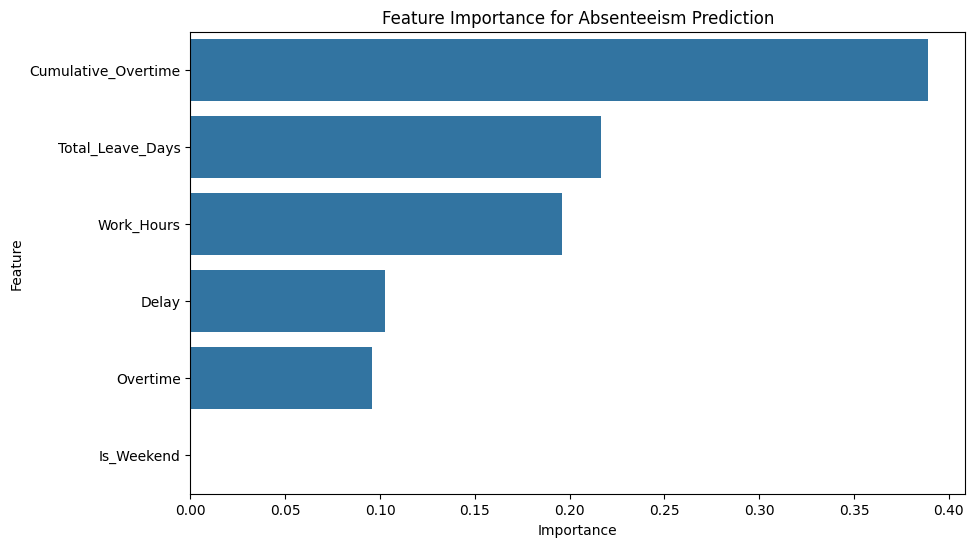

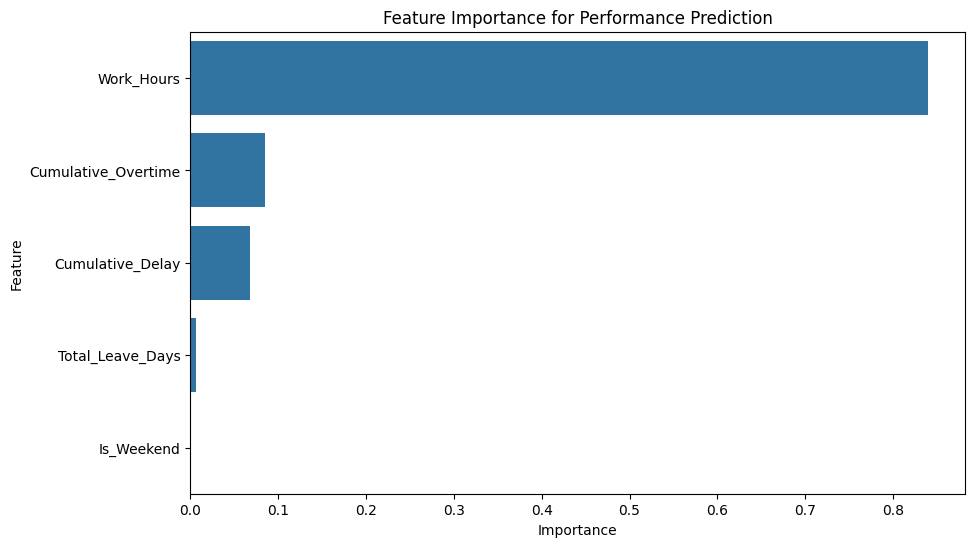

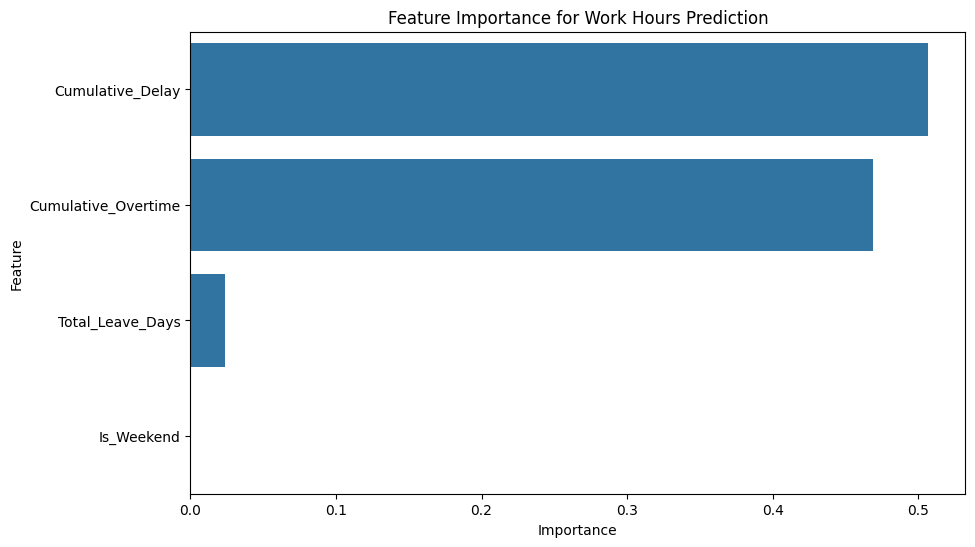

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot feature importance
def plot_feature_importance(model, features, task_name):
    importance = model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title(f'Feature Importance for {task_name}')
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, task_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {task_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Task 1: Absenteeism - Confusion Matrix and Feature Importance
# plot_confusion_matrix(y_test, y_pred, 'Absenteeism Prediction')
plot_feature_importance(clf, X_absenteeism.columns, 'Absenteeism Prediction')

# Task 2: Performance - Confusion Matrix and Feature Importance
# plot_confusion_matrix(y_test, y_pred, 'Performance Prediction')
plot_feature_importance(clf_performance, X_performance.columns, 'Performance Prediction')

# Task 3: Work Hours - Feature Importance (Regression Task)
plot_feature_importance(regressor, X_work_hours.columns, 'Work Hours Prediction')

# Task 4: Turnover - Confusion Matrix and Feature Importance
# plot_confusion_matrix(y_test, y_pred, 'Turnover Prediction')
# plot_feature_importance(clf_turnover, X_turnover.columns, 'Turnover Prediction')
